In [1]:
#imports
import numpy as np
import json
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree, preprocessing
import statsmodels.api as sm

In [2]:
#raw data
df = pd.read_csv('Fires.csv')

C:\Users\Max\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (8,10,11,12,13,14,15,16,17,18,35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,63.0,Plumas,NaN
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,61.0,Placer,NaN
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,17.0,El Dorado,NaN
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,3.0,Alpine,NaN
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,3.0,Alpine,NaN


In [4]:
#Preprocessing
df['DISC_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['CONTAIN_DATE'] = pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['DURATION'] = df['CONTAIN_DATE'] - df['DISC_DATE']

le = preprocessing.LabelEncoder()
df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])
df['STATE'] = le.fit_transform(df['STATE'])

In [5]:
#filtering out unimportant columns
data = df[['FOD_ID',
           'FPA_ID',
           'FIRE_CODE',
           'FIRE_NAME',
           'FIRE_YEAR',
           'DISCOVERY_DATE',
           'DISCOVERY_DOY',
           'DISCOVERY_TIME',
           'STAT_CAUSE_CODE',
           'STAT_CAUSE_DESCR',
           'CONTAIN_DATE',
           'CONT_DOY',
           'CONT_TIME',
           'FIRE_SIZE',
           'FIRE_SIZE_CLASS',
           'LATITUDE',
           'LONGITUDE',
           'STATE',
           'COUNTY',
           'DISC_DATE',
           'CONTAIN_DATE',
           'DURATION']]

In [6]:
#dropping rows with NA
data = data.dropna()
data.head()

,FOD_ID,FPA_ID,FIRE_CODE,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,...,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,DISC_DATE,CONTAIN_DATE,DURATION
0,1,FS-1418826,BJ8K,FOUNTAIN,2005,2453403.5,33,1300.0,9.0,7,...,1730.0,0.10,A,40.036944,-121.005833,4,63,2005-02-02,2005-02-02,0 days
1,2,FS-1418827,AAC0,PIGEON,2004,2453137.5,133,845.0,1.0,6,...,1530.0,0.25,A,38.933056,-120.404444,4,61,2004-05-12,2004-05-12,0 days
2,3,FS-1418835,A32W,SLACK,2004,2453156.5,152,1921.0,5.0,3,...,2024.0,0.10,A,38.984167,-120.735556,4,17,2004-05-31,2004-05-31,0 days
17,18,FS-1418881,BHA3,FREDS,2004,2453291.5,287,1618.0,2.0,4,...,1800.0,7700.00,G,38.780000,-120.260000,4,17,2004-10-13,2004-10-17,4 days
19,20,FS-1418887,AVPA,SPRING,2004,2453160.5,156,1030.0,1.0,6,...,1400.0,0.10,A,33.440833,-105.720556,32,27,2004-06-04,2004-06-04,0 days


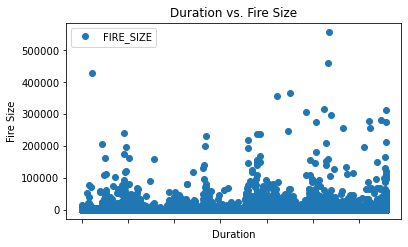

In [7]:
#graph of intial data
data.plot(x='DURATION', y='FIRE_SIZE', style='o')
plt.title('Duration vs. Fire Size')
plt.xlabel('Duration')
plt.ylabel('Fire Size')
plt.show()

# Linear Regression

In [8]:
#set X and y as fire duration and fire size
X = data['DURATION'].dt.total_seconds().values
y = data['FIRE_SIZE'].values

In [9]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [10]:
#creating regression model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [11]:
#intercept and slope of X
print(regression_model.intercept_)
print(regression_model.coef_)

[123.53250974]
[[0.00075005]]


In [12]:
#create predicted values from test set
y_pred = regression_model.predict(X_test)

In [13]:
#compare actual vs predicted values
test_vs_pred = pd.DataFrame({'Actual': np.squeeze(y_test), 'Predicted': np.squeeze(y_pred)})
test_vs_pred

,Actual,Predicted
0,2.00,123.532510
1,0.10,253.141877
2,25.00,188.337193
3,1.00,188.337193
4,0.88,447.555928
...,...,...
49353,0.10,123.532510
49354,5.00,123.532510
49355,0.80,123.532510
49356,0.10,123.532510


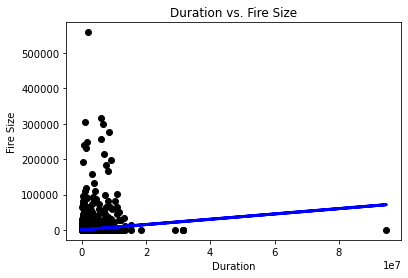

In [14]:
#plot
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.title('Duration vs. Fire Size')
plt.xlabel('Duration')
plt.ylabel('Fire Size')
plt.show()

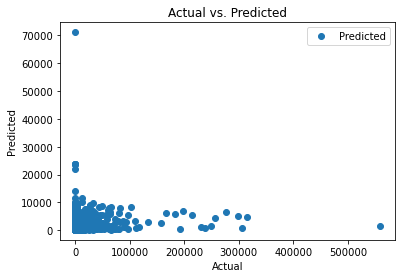

In [15]:
#plot actual vs predicted
test_vs_pred.plot(x='Actual', y='Predicted', style='o')
plt.title('Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [25]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Normalized Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)) / np.average(y_test))

Mean Absolute Error: 490.99236689246817
Mean Squared Error: 29499645.717345335
Root Mean Squared Error: 5431.357631140241
Normalized Root Mean Squared Error: 18.56945542143859


# Multiple Linear Regression

In [26]:
#set X and y as important variables and fire size
X1 = data[['STAT_CAUSE_DESCR', 'LATITUDE', 'LONGITUDE', 'DURATION']]
X1['DURATION'] = data['DURATION'].dt.total_seconds().values
y1 = data['FIRE_SIZE'].values


# X1 = data[['FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'DURATION']]
# X1['DURATION'] = data['DURATION'].dt.total_seconds().values
# y1 = data['STAT_CAUSE_DESCR'].values

C:\Users\Max\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
#split data into training and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=0)

In [28]:
#creating regression model
regression_model1 = LinearRegression()
regression_model1.fit(X_train1, y_train1)

LinearRegression()

In [29]:
#most optimal coefficients for all attributes
coeff_df = pd.DataFrame(regression_model1.coef_, X1.columns, columns=['Coefficient'])
coeff_df

,Coefficient
STAT_CAUSE_DESCR,7.371022
LATITUDE,9.643195
LONGITUDE,-7.062754
DURATION,0.000743


In [35]:
#create predicted values from test set
y_pred1 = regression_model1.predict(X_test1)

In [31]:
#compare actual vs predicted values
test_vs_pred1 = pd.DataFrame({'Actual': y_test1, 'Predicted': y_pred1})
test_vs_pred1

,Actual,Predicted
0,2.00,180.040139
1,0.10,233.480561
2,25.00,99.305511
3,1.00,78.376331
4,0.88,291.780023
...,...,...
49353,0.10,34.342360
49354,5.00,232.640197
49355,0.80,252.955748
49356,0.10,-141.510259


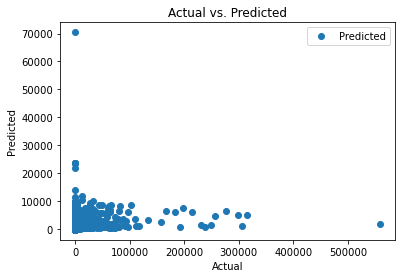

In [32]:
#plot actual vs predicted
test_vs_pred1.plot(x='Actual', y='Predicted', style='o')
plt.title('Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [34]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test1, y_pred1))
print('Mean Squared Error:', metrics.mean_squared_error(y_test1, y_pred1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred1)))
print('Normalized Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)) / np.average(y_test))

Mean Absolute Error: 508.1835301214305
Mean Squared Error: 29485953.314058773
Root Mean Squared Error: 5430.096989378622
Normalized Root Mean Squared Error: 18.56945542143859
